## Running preprocessing and data steps 

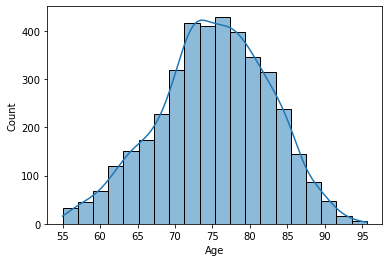

In [1]:
import optuna
import h5py    
from numba import jit
import numpy as np    
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import time
from time import time
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn  import metrics
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import sys
import warnings

#import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from scipy.stats import skew
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
#from xgboost import XGBRegressor
def distribution_plot(data,title,method):
    title = 'Distribution of Subjects Age '+title
    fname = method+'/' +title
    ax = sns.histplot(data,kde=True,bins = 20).set(title=title)
    plt.tight_layout()
    plt.savefig(fname)
    plt.clf()
    return ax

def all_metrics_to_file(test,pred_test,val,pred_val,method = 'ML',data = 'Whole Control',fileOut = 'MLResults.csv', save_metrics = True):
    mae = mean_absolute_error(test, pred_test)
    ev = explained_variance_score(test, pred_test)
    cor_p = pearsonr(test, pred_test)[0]
    r2_val = cor_p**2
    id_name = method + ' Test'
    print("\tTest Explained variance:", ev)
    print("\tTest Mean absolute error:", mae)
    print("\tTest Correlation:", cor_p)
    print("\tTest R2 score:", r2_val)
    print()
    res_df_test = pd.DataFrame(data = [method,mae,ev,cor_p,r2_val,data],index=['Method','Mean Absolute Error','Explained Variance','Correlation','R2 Score','Dataset Used'],columns = ['Test'])
    res_df_test = res_df_test.T
    mae_v = mean_absolute_error(val, pred_val)
    ev_v = explained_variance_score(val, pred_val)
    cor_p_v = pearsonr(val, pred_val)[0]
    r2_val_v = cor_p**2
    id_name = method + ' Validation'
    print("\tValidation Explained variance:", ev_v)
    print("\tValidation Mean absolute error:", mae_v)
    print("\tValidation Correlation:", cor_p_v)
    print("\tValidation R2 score:", r2_val_v)
    print()
    res_df_val = pd.DataFrame(data = [method,mae_v,ev_v,cor_p_v,r2_val_v,data],index=['Method','Mean Absolute Error','Explained Variance','Correlation','R2 Score','Dataset Used'],columns = ['Validation'])
    res_df_val = res_df_val.T
    final_res = pd.concat([res_df_test,res_df_val])
    if save_metrics:
        final_res.to_csv(fileOut, mode='a', header=not os.path.exists(fileOut))

def scat_plot(yt_pred,y_test,yv_pred,y_valid,title,method):
    title2 = 'Test Subjects '+title
    fname = method+'/Test_' +title
    data = pd.DataFrame(data = [list(yt_pred),list(y_test)], index=['Predicted','Test'])
    data = data.transpose()
    ax = sns.regplot(x='Predicted',y='Test',data = data).set(title=title2,xlim = (35,80),ylim = (35,80))
    plt.tight_layout()
    plt.savefig(fname)
    plt.clf()
    title_2 = 'Validation Subjects '+title
    fname = method+'/Valid_' +title
    data = pd.DataFrame(data = [list(yv_pred),list(y_valid)], index=['Predicted','Validation'])
    data = data.transpose()
    ax2 = sns.regplot(x='Predicted',y='Validation',data = data).set(title=title2,xlim = (35,80),ylim = (35,80))
    plt.tight_layout()
    plt.savefig(fname)
    plt.clf()
    return ax,ax2
## Obtaining difference age_p2

def bias_correction(age_t,age_p1, degree, title_set = 'Male UKBB Subjects'):
    
    b_model = np.polyfit(age_t,age_p1,deg=degree)
    b_model_out = np.poly1d(b_model)
    age_p2 = []
    for i in range(0,len(age_t)):
        age_p2.append(b_model_out(age_t[i]))
    ## Using formula for predited Age correction --> age_pc
    # age_pc = age_p1 - age_p2 + age_t
    age_pc = []
    for i in range(0,len(age_t)):
        age_pc.append(age_p1[i] - age_p2[i] + age_t[i])
    
    fig, ax = plt.subplots(figsize = (9, 9))
    ax.scatter(age_t,age_pc,s=40, alpha=0.7, edgecolors="k")
    #ax.plot(xseq, a + b * xseq + c*(xseq**2) +d*(xseq**3), color="k", lw=2.5)
    ax.plot([38,72], [38,72], 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Age')
    plt.ylabel('Corrected Predicted Age')
    sts= "Mean Absolute Error " + str(round(mean_absolute_error(age_t, age_pc),3))
    plt.text(55, 40, sts, fontsize = 14)
    sts= "Corrected Polynomial Degree " + str(degree)
    plt.text(55, 38, sts, fontsize = 14)
    plt.title(' Actual Age vs Corrected Predicted Age '+title_set)
    
    return age_pc,b_model_out

def get_figure_prediction(actual_age, predicted_age, deg = 3, range_fig = [35,75],range_txt_x = 55,range_txt_y = [40,38], Title_add = "UKBB Test Data"):
    fig, ax = plt.subplots(figsize = (9, 9))
    training_age_t = actual_age
    training_age_p1 = predicted_age

    ax.scatter(training_age_t,
                      training_age_p1,s=40, alpha=0.7, edgecolors="k")
    d, c, b, a = np.polyfit(training_age_t,
                      training_age_p1,deg=deg)

    xseq = np.linspace(min(training_age_t),np.max(training_age_t), num=100)
    ax.plot(xseq, a + b * xseq + c*(xseq**2) +d*(xseq**3), color="k", lw=2.5)
    ax.plot(range_fig, range_fig, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    sts= "Mean Absolute Error " + str(round(mean_absolute_error(training_age_t, training_age_p1),2))
    plt.text(range_txt_x, range_txt_y[0], sts, fontsize = 14)
    sts= "Pearson Correlation " + str(round(pearsonr(training_age_t, training_age_p1)[0],2))
    plt.text(range_txt_x, range_txt_y[1], sts, fontsize = 14)
    plt.xlim(range_fig)
    plt.ylim(range_fig)
    plt.title(' Actual Age vs Predicted Age ('+Title_add+')')
    
def correct_w_model(age_t,age_p1,b_model_out_poly):
    #age_t = list(Y_ukbb_test)
    #age_p1 = mlp_regressor_whole_population.predict(normalized_X_ukbb_test)
    age_p2 = []
    for i in range(0,len(age_t)):
        age_p2.append(b_model_out_poly(age_t[i]))
    age_pc = []
    for i in range(0,len(age_t)):
        age_pc.append(age_p1[i] - age_p2[i] + age_t[i])
        
    return age_pc

import scipy
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix,recall_score,precision_score,log_loss,roc_auc_score,roc_curve




mri_roi = pd.read_csv('Data/ProcessedMRI_ROI.csv',index_col = 'Unnamed: 0')
subjects_to_test = list(mri_roi.index)

x = pd.read_csv('Data/First_Time_Point_Metabolomics_Control.csv',index_col = 'eid')
x = np.log2(np.exp(x))
y = pd.read_csv('Data/First_Time_Point_Demographics_Control.csv',index_col = 'eid')
y = y.Age_at_TestCenter

bins = np.linspace(0, len(y),20)
y_binned = np.digitize(y, bins)
scaler = StandardScaler().fit(x)
X_ukbb_train, X_ukbb_test, Y_ukbb_train, Y_ukbb_test = train_test_split(x, y,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

bins = np.linspace(0, len(Y_ukbb_train),20)
y_binned = np.digitize(Y_ukbb_train, bins)
X_ukbb_train, X_ukbb_val, Y_ukbb_train, Y_ukbb_val = train_test_split(X_ukbb_train, Y_ukbb_train,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

normalized_X_ukbb_train = pd.DataFrame(
  scaler.transform(X_ukbb_train),
  columns = x.columns
  )
normalized_X_ukbb_test = pd.DataFrame(
  scaler.transform(X_ukbb_test),
  columns = x.columns
  )
normalized_X_ukbb_val = pd.DataFrame(
  scaler.transform(X_ukbb_val),
  columns = x.columns
  )
#Coding	Meaning
#0	Female
#1	Male


y = pd.read_csv('Data/First_Time_Point_Demographics_Control.csv',index_col = 'eid')
y_ukbb_male = y[y.Sex == 1].Age_at_TestCenter
y_ukbb_female = y[y.Sex == 0].Age_at_TestCenter

x_ukbb_male = x[x.index.isin(y_ukbb_male.index)]
x_ukbb_female = x[x.index.isin(y_ukbb_female.index)]


bins = np.linspace(0, len(y_ukbb_male),20)
y_binned = np.digitize(y_ukbb_male, bins)
scaler = StandardScaler().fit(x_ukbb_male)
X_male_ukbb_train, X_male_ukbb_test, Y_male_ukbb_train, Y_male_ukbb_test = train_test_split(x_ukbb_male, y_ukbb_male,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

bins = np.linspace(0, len(Y_male_ukbb_train),20)
y_binned = np.digitize(Y_male_ukbb_train, bins)
X_male_ukbb_train, X_male_ukbb_val, Y_male_ukbb_train, Y_male_ukbb_val = train_test_split(X_male_ukbb_train, Y_male_ukbb_train,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

normalized_X_male_ukbb_train = pd.DataFrame(
  scaler.transform(X_male_ukbb_train),
  columns = x_ukbb_male.columns
  )
normalized_X_male_ukbb_test = pd.DataFrame(
  scaler.transform(X_male_ukbb_test),
  columns = x_ukbb_male.columns
  )
normalized_X_male_ukbb_val = pd.DataFrame(
  scaler.transform(X_male_ukbb_val),
  columns = x_ukbb_male.columns
  )

bins = np.linspace(0, len(y_ukbb_female),20)
y_binned = np.digitize(y_ukbb_female, bins)
scaler = StandardScaler().fit(x_ukbb_female)
X_female_ukbb_train, X_female_ukbb_test, Y_female_ukbb_train, Y_female_ukbb_test = train_test_split(x_ukbb_female, y_ukbb_female,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

bins = np.linspace(0, len(Y_female_ukbb_train),20)
y_binned = np.digitize(Y_female_ukbb_train, bins)
X_female_ukbb_train, X_female_ukbb_val, Y_female_ukbb_train, Y_female_ukbb_val = train_test_split(X_female_ukbb_train, Y_female_ukbb_train,
        test_size=0.1, shuffle = True, random_state = 42,stratify=y_binned)

normalized_X_female_ukbb_train = pd.DataFrame(
  scaler.transform(X_female_ukbb_train),
  columns = x_ukbb_female.columns
  )
normalized_X_female_ukbb_test = pd.DataFrame(
  scaler.transform(X_female_ukbb_test),
  columns = x_ukbb_female.columns
  )
normalized_X_female_ukbb_val = pd.DataFrame(
  scaler.transform(X_female_ukbb_val),
  columns = x_ukbb_female.columns
  )





import itertools
adni_met = pd.read_csv('ADNI_Rearranged_New_Input_data.csv')
subj_info = pd.read_csv('SubjectId_ADNI.csv')
adni_met = adni_met.transpose()
import random
random.seed(42)
adni_dem = pd.read_csv('ADNI_Demographics.csv')
out_og = adni_dem[list(adni_dem.Diagnosis.isin(['Controls','LMCI','EMCI','AD']))]
#out_og_ = out_og[(out_og['age'] > 40) & (out_og['age'] < 70)]

subj_info['Age'] = 0
subj_info['Sex'] = 'female'
subj_info['Diagnosis'] = 'Controls'
for i in adni_dem.RID:
    temp_idx = subj_info.RID == i
    baseline_idx_w_dem = subj_info.VISCODE2 == 'bl'
    baseline_idx_w_dem = [a and b for a, b in zip(temp_idx, baseline_idx_w_dem)]
    baseline_idx_n_dem = [a and b for a, b in zip(temp_idx, subj_info.VISCODE2 != 'bl')]

    subj_info.loc[baseline_idx_w_dem,'Age'] = float(list(adni_dem.age[adni_dem.RID == i])[0])
    subj_info.loc[baseline_idx_w_dem,'Sex'] = list(adni_dem.Sex[adni_dem.RID == i])[0]
    subj_info.loc[baseline_idx_w_dem,'Diagnosis']  = list(adni_dem.Diagnosis[adni_dem.RID == i])[0]
    for k in list(subj_info[baseline_idx_n_dem].index):
        subj_info.loc[k,'Age'] = float(list(adni_dem.age[adni_dem.RID == i])[0]) + int(subj_info.VISCODE2[k].split('m')[1])/12
        subj_info.loc[k,'Sex'] = list(adni_dem.Sex[adni_dem.RID == i])[0]
        subj_info.loc[k,'Diagnosis']  = list(adni_dem.Diagnosis[adni_dem.RID == i])[0]
    
    
subj_info_1 = subj_info.loc[list(subj_info.RID.isin(out_og.RID)),:]
#subj_info_2 = subj_info_1[list(subj_info_1.RID.isin(out_og_.RID))]
#subj_info_2 = subj_info_1[list(subj_info_1.VISCODE2 == 'bl')]
subj_info_2 = subj_info_1
bl_control_subjects = subj_info_1.loc[(subj_info_1.VISCODE2 == 'bl') & (subj_info_1.Diagnosis == 'Controls')]
index_control = subj_info_2.index
adni_all = adni_met.loc[list(subj_info_2.Sample_id),:]


out_og = subj_info_2['Age']
out_og.index = subj_info_2['RID']
sns.histplot(out_og,kde=True,bins = 20)

male_adni_x = adni_all[adni_all.index.isin(subj_info_2.Sample_id[subj_info_2.Sex == 'Male'])]
female_adni_x = adni_all[adni_all.index.isin(subj_info_2.Sample_id[subj_info_2.Sex == 'Female'])]

male_adni_y = subj_info_2[subj_info_2.Sample_id.isin(male_adni_x.index)]
male_adni_y.index = male_adni_y.Sample_id
female_adni_y = subj_info_2[subj_info_2.Sample_id.isin(female_adni_x.index)]
female_adni_y.index = female_adni_y.Sample_id

male_adni_x_controls = male_adni_x[male_adni_x.index.isin(male_adni_y.Sample_id[male_adni_y.Diagnosis == 'Controls'])]
female_adni_x_controls = female_adni_x[female_adni_x.index.isin(female_adni_y.Sample_id[female_adni_y.Diagnosis == 'Controls'])]

male_adni_y = male_adni_y.Age
female_adni_y = female_adni_y.Age

male_adni_y_controls = subj_info_2[subj_info_2.Sample_id.isin(male_adni_x_controls.index)].Age
male_adni_y_controls.index = male_adni_x_controls.index
female_adni_y_controls = subj_info_2[subj_info_2.Sample_id.isin(female_adni_x_controls.index)].Age
female_adni_y_controls.index = female_adni_x_controls.index

scaler = StandardScaler().fit(male_adni_x)
normalized_male_adni_x = pd.DataFrame(
  scaler.transform(male_adni_x),
  columns = male_adni_x.columns
  )
normalized_male_adni_x.index = male_adni_y.index
scaler = StandardScaler().fit(female_adni_x)
normalized_female_adni_x = pd.DataFrame(
  scaler.transform(female_adni_x),
  columns = female_adni_x.columns
  )
normalized_female_adni_x.index = female_adni_y.index

scaler = StandardScaler().fit(male_adni_x_controls)
normalized_male_adni_x_controls = pd.DataFrame(
  scaler.transform(male_adni_x_controls),
  columns = male_adni_x_controls.columns
  )
normalized_male_adni_x_controls.index = male_adni_y_controls.index

scaler = StandardScaler().fit(female_adni_x_controls)
normalized_female_adni_x_controls = pd.DataFrame(
  scaler.transform(female_adni_x_controls),
  columns = female_adni_x.columns
  )
normalized_female_adni_x_controls.index = female_adni_y_controls.index

scaler = StandardScaler().fit(adni_all)
normalized_adni_x = pd.DataFrame(
  scaler.transform(adni_all),
  columns = adni_all.columns
  )


## Running best model - Whole UKBB Population

	Mean Absolute Error Test 5.447151739986686
	PearsonCorrelation for Test (0.5817394883516891, 0.0)
	Mean Absolute Error Validation 5.458933810753619
	PearsonCorrelation for Validation (0.5765315298820912, 0.0)


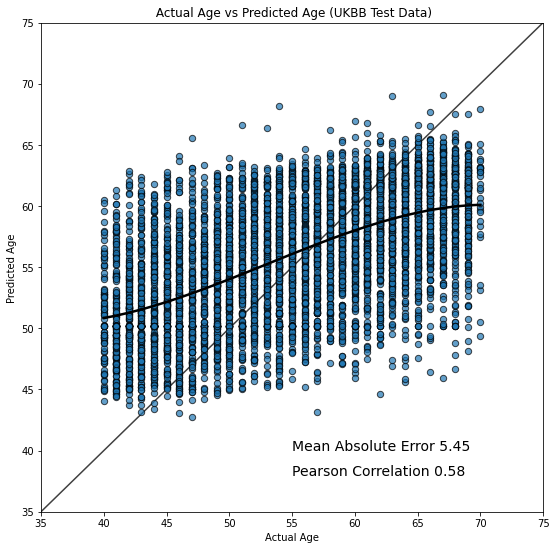

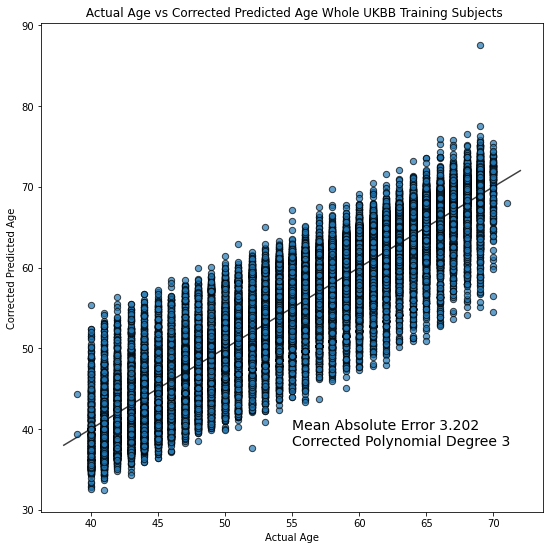

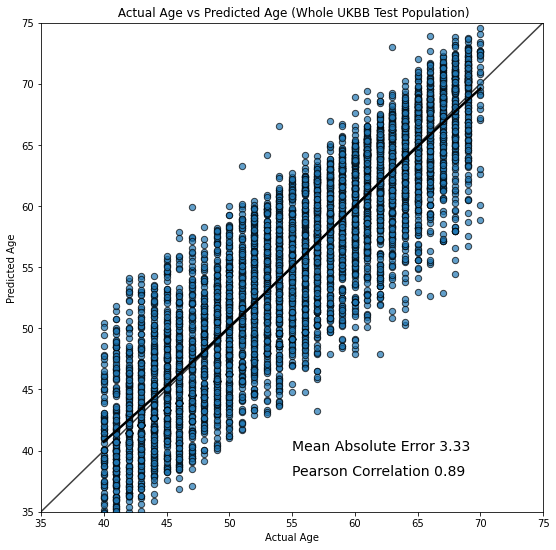

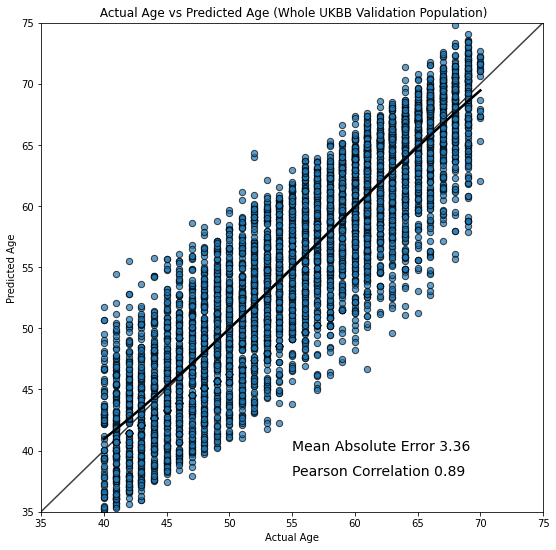

In [3]:
## Running Best Model
deg_use = 3
mlp_regressor_whole_population = MLPRegressor(
                            hidden_layer_sizes=(25, 75, 100),
                            activation='relu',
                            #solver=solver,
                            learning_rate='invscaling',
                            momentum = 0.8570072003082716,
                            learning_rate_init=0.007430075847532571,random_state = 42
                            #early_stopping=True
                            )
mlp_regressor_whole_population.fit(normalized_X_ukbb_train,Y_ukbb_train)

## Obtaining the model statistics
print("\tMean Absolute Error Test",mean_absolute_error(Y_ukbb_test, mlp_regressor_whole_population.predict(normalized_X_ukbb_test)))
print("\tPearsonCorrelation for Test",pearsonr(Y_ukbb_test, mlp_regressor_whole_population.predict(normalized_X_ukbb_test)))



print("\tMean Absolute Error Validation",mean_absolute_error(Y_ukbb_val, mlp_regressor_whole_population.predict(normalized_X_ukbb_val)))
print("\tPearsonCorrelation for Validation",pearsonr(Y_ukbb_val, mlp_regressor_whole_population.predict(normalized_X_ukbb_val)))

## Saving Dataframe
predicated_age_whole_population = mlp_regressor_whole_population.predict(normalized_X_ukbb_test)
#sns.histplot(predicated_age_whole_population,kde=True).set(title='Predicted Age by MLP')
predicted_dataframe_whole_population = pd.DataFrame(list(zip(predicated_age_whole_population, Y_ukbb_test)),index = Y_ukbb_test.index, columns = ['Predicted_Age','Actual_Age'])
predicted_dataframe_whole_population["Difference"] = predicted_dataframe_whole_population["Predicted_Age"] - predicted_dataframe_whole_population["Actual_Age"]
#sns.histplot(predicted_dataframe['Difference'],kde=True,bins = 20)
#predicted_dataframe.to_csv('Data/Predicted_Age_MLP.csv')

## Visulaizing the biased model
get_figure_prediction(Y_ukbb_test, mlp_regressor_whole_population.predict(normalized_X_ukbb_test))


## Correcting for age bias in the model
# obtaining th bias correction model from training data
poly_corrected_age,b_model_out_poly_whole = bias_correction(age_t = list(Y_ukbb_train),age_p1 = mlp_regressor_whole_population.predict(normalized_X_ukbb_train),degree = deg_use,title_set='Whole UKBB Training Subjects')

#Using the bias correction model on testing data
age_pc_test = correct_w_model(list(Y_ukbb_test),mlp_regressor_whole_population.predict(normalized_X_ukbb_test),b_model_out_poly_whole)
age_pc_val = correct_w_model(list(Y_ukbb_val),mlp_regressor_whole_population.predict(normalized_X_ukbb_val),b_model_out_poly_whole)


## Visulaizing the bias corrected model
get_figure_prediction(list(Y_ukbb_test), age_pc_test, Title_add='Whole UKBB Test Population')
get_figure_prediction(list(Y_ukbb_val), age_pc_val,Title_add='Whole UKBB Validation Population' )


predicted_dataframe_whole_population["Corrected_Predicted_Age"] = age_pc_test


## Running best male model

	Mean Absolute Error Test 5.952530850547572
	PearsonCorrelation for Test (0.5106980083367736, 5.498752597460432e-214)
	Mean Absolute Error Validation 5.756314216034692
	PearsonCorrelation for Validation (0.5315284086192675, 1.19722402603514e-211)


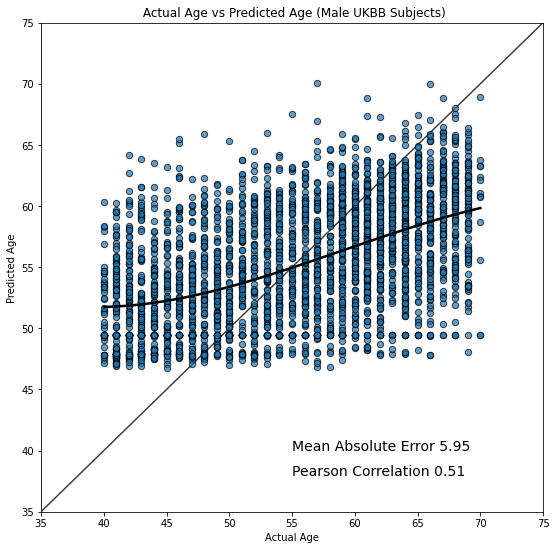

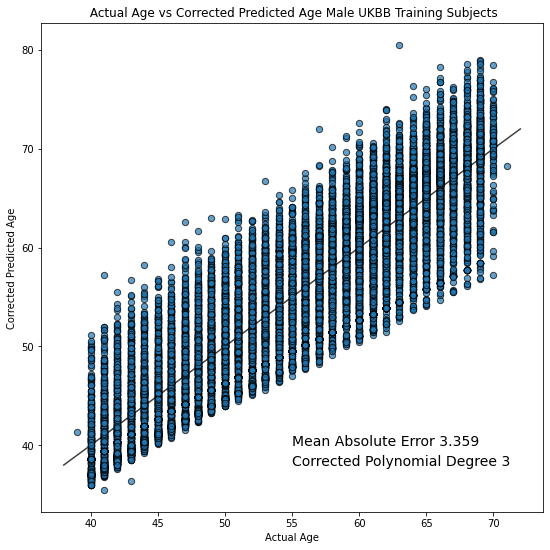

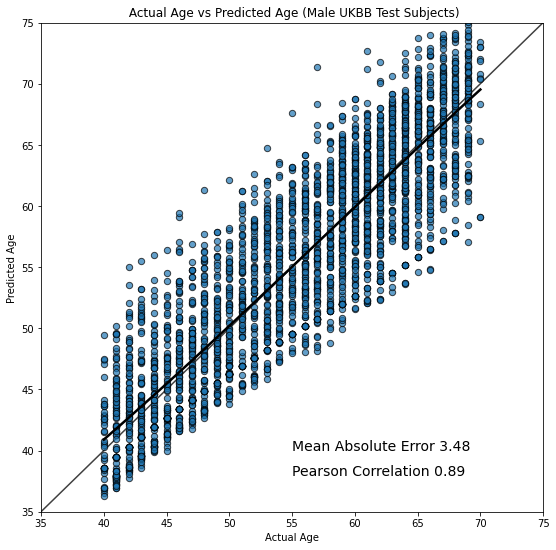

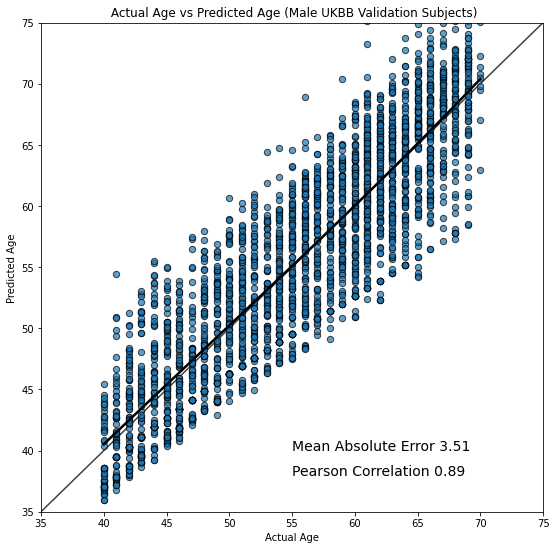

In [35]:
## Running Best Model
mlp_regressor_male_population = MLPRegressor(
                            hidden_layer_sizes=(25, 50, 75, 100),
                            activation='relu',
                            momentum= 0.320464912514306,
                            learning_rate='adaptive',
                            learning_rate_init=0.012975784121150543,random_state=42
                            #early_stopping=True
                            )
mlp_regressor_male_population.fit(normalized_X_male_ukbb_train,Y_male_ukbb_train)

## Obtaining the model statistics
print("\tMean Absolute Error Test",mean_absolute_error(Y_male_ukbb_test, mlp_regressor_male_population.predict(normalized_X_male_ukbb_test)))
print("\tPearsonCorrelation for Test",pearsonr(Y_male_ukbb_test, mlp_regressor_male_population.predict(normalized_X_male_ukbb_test)))
print("\tMean Absolute Error Validation",mean_absolute_error(Y_male_ukbb_val, mlp_regressor_male_population.predict(normalized_X_male_ukbb_val)))
print("\tPearsonCorrelation for Validation",pearsonr(Y_male_ukbb_val, mlp_regressor_male_population.predict(normalized_X_male_ukbb_val)))

## Saving Dataframe
predicated_age_male_population = mlp_regressor_male_population.predict(normalized_X_male_ukbb_test)
predicated_age_male_population = pd.DataFrame(list(zip(predicated_age_male_population, Y_male_ukbb_test)),index = Y_male_ukbb_test.index, columns = ['Predicted_Age','Actual_Age'])
predicated_age_male_population["Difference"] = predicated_age_male_population["Predicted_Age"] - predicated_age_male_population["Actual_Age"]
#sns.histplot(predicted_dataframe['Difference'],kde=True,bins = 20)
#predicted_dataframe.to_csv('Data/Predicted_Age_MLP.csv')

## Visulaizing the biased model
get_figure_prediction(Y_male_ukbb_test, mlp_regressor_male_population.predict(normalized_X_male_ukbb_test),Title_add='Male UKBB Subjects')


## Correcting for age bias in the model
# obtaining th bias correction model from training data
poly_corrected_age,b_model_out_poly_male = bias_correction(age_t = list(Y_male_ukbb_train),age_p1 = mlp_regressor_male_population.predict(normalized_X_male_ukbb_train),degree = deg_use,title_set='Male UKBB Training Subjects')

#Using the bias correction model on testing data
age_pc_test = correct_w_model(list(Y_male_ukbb_test),mlp_regressor_male_population.predict(normalized_X_male_ukbb_test),b_model_out_poly_male)
age_pc_val = correct_w_model(list(Y_male_ukbb_val),mlp_regressor_male_population.predict(normalized_X_male_ukbb_val),b_model_out_poly_male)

## Visulaizing the bias corrected model
get_figure_prediction(list(Y_male_ukbb_test), age_pc_test, Title_add='Male UKBB Test Subjects')
get_figure_prediction(list(Y_male_ukbb_val), age_pc_val, Title_add='Male UKBB Validation Subjects')


predicated_age_male_population["Corrected_Predicted_Age"] = age_pc_test
